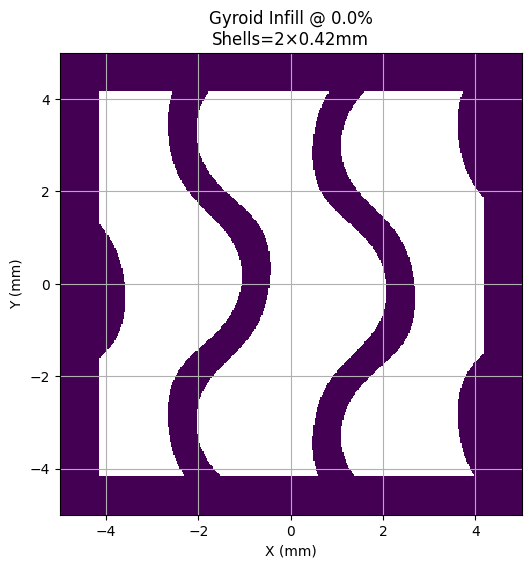

=== Gyroid Infill 0.0% ===
Total Area (approx)    = 46.3923 mm²
Shell Area (approx)    = 31.2661 mm²
Infill Area (approx)   = 15.1262 mm²
Centroid (x_c, y_c)    = (0.0410, -0.0067)
I_x (about centroid)   = 529.1912
I_y (about centroid)   = 526.7176
I_xy (product)         = 0.6072
Polar moment, J        = 1055.9088



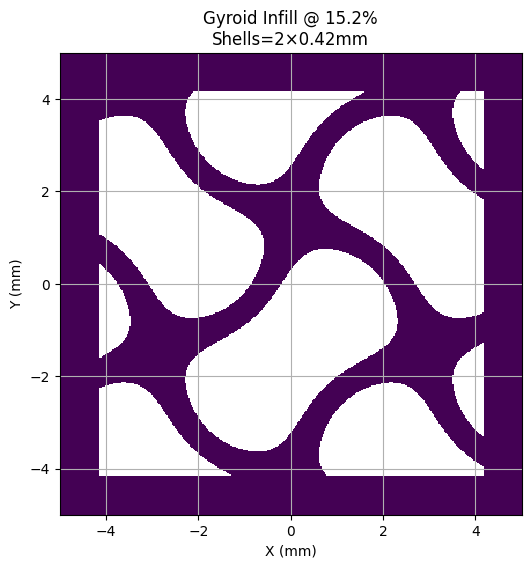

=== Gyroid Infill 15.2% ===
Total Area (approx)    = 54.1982 mm²
Shell Area (approx)    = 31.2661 mm²
Infill Area (approx)   = 22.9320 mm²
Centroid (x_c, y_c)    = (0.0174, -0.0001)
I_x (about centroid)   = 575.6136
I_y (about centroid)   = 574.8561
I_xy (product)         = 0.1255
Polar moment, J        = 1150.4696



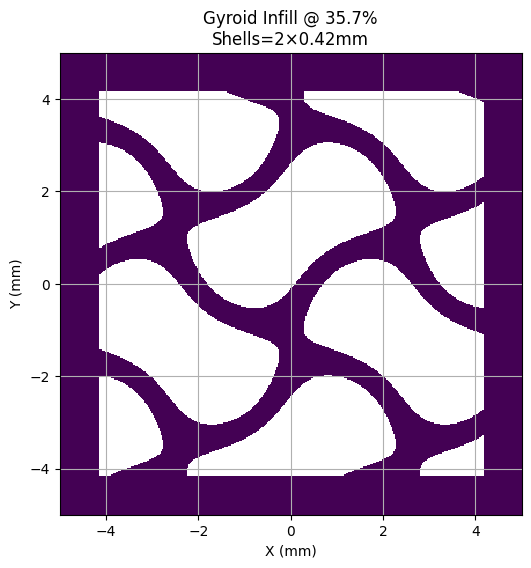

=== Gyroid Infill 35.7% ===
Total Area (approx)    = 51.5254 mm²
Shell Area (approx)    = 31.2661 mm²
Infill Area (approx)   = 20.2593 mm²
Centroid (x_c, y_c)    = (-0.0067, -0.0459)
I_x (about centroid)   = 554.8102
I_y (about centroid)   = 550.3740
I_xy (product)         = -3.2256
Polar moment, J        = 1105.1842



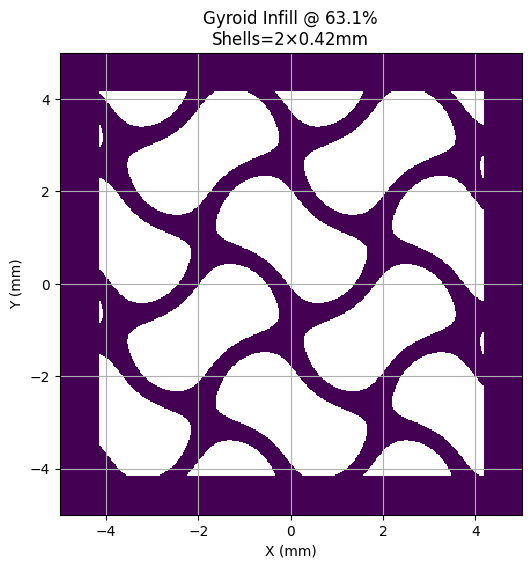

=== Gyroid Infill 63.1% ===
Total Area (approx)    = 53.5248 mm²
Shell Area (approx)    = 31.2661 mm²
Infill Area (approx)   = 22.2587 mm²
Centroid (x_c, y_c)    = (0.0024, 0.0276)
I_x (about centroid)   = 567.0206
I_y (about centroid)   = 579.3010
I_xy (product)         = -1.8171
Polar moment, J        = 1146.3216



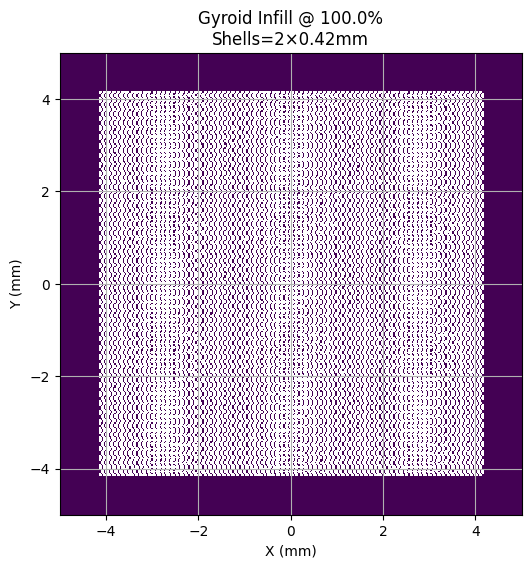

=== Gyroid Infill 100.0% ===
Total Area (approx)    = 47.2145 mm²
Shell Area (approx)    = 31.2661 mm²
Infill Area (approx)   = 15.9484 mm²
Centroid (x_c, y_c)    = (-0.0006, 0.0005)
I_x (about centroid)   = 534.3228
I_y (about centroid)   = 535.7847
I_xy (product)         = -0.0399
Polar moment, J        = 1070.1076



In [1]:
import numpy as np
import matplotlib.pyplot as plt

def compute_area_moments(XX, YY, mask):
    dx = XX[0, 1] -.
Suženi struk epruvete daje nam manju površinu poprečnog presjeka kako bi mogli garantirati
da će zona loma stati u suženi dio. Kako ne možemo pouzdano izraditi struk, a opet želimo
dobiti manju površinu poprečnog presjeka u sredini epruvete (zoni loma), možemo napraviti
kompromis sa varijacijom postotka ispune kroz dužinu epruv XX[0, 0]
    dy = YY[1, 0] - YY[0, 0]
    dA = dx * dy

    A = np.count_nonzero(mask) * dA
    if A == 0:
        return A, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    x_vals = XX[mask]
    y_vals = YY[mask]
    x_c = np.sum(x_vals * dA) / A
    y_c = np.sum(y_vals * dA) / A
    x_shift = x_vals - x_c
    y_shift = y_vals - y_c

    I_x = np.sum((y_shift**2) * dA)
    I_y = np.sum((x_shift**2) * dA)
    I_xy = np.sum((x_shift * y_shift) * dA)
    J = I_x + I_y

    return A, x_c, y_c, I_x, I_y, I_xy, J

def geometric_infill_fractions(width, layer_width, shell_layers, steps=5):
    A_total = width ** 2
    shell_thickness = 2 * layer_width * shell_layers
    A_shell = A_total - (width - shell_thickness) ** 2
    r = (A_total / A_shell) ** (1 / (steps - 1))
    return [(A_shell * r**i - A_shell) / (A_total - A_shell) for i in range(steps)]

def gyroid_infill_rectangular_with_shell(
    width,
    height,
    infill_fraction,  # Now passed as 0.0 to 1.0
    z_height=0.0,
    line_thickness=0.1,
    shell_layers=3,
    layer_width=0.4,
    plot=True
):
    base_frequency = 1.0
    max_multiplier = 5.0
    #scale_factor = base_frequency + (max_multiplier - 1.0) * infill_fraction
    scale_factor = base_frequency / np.sqrt(1.0 - 0.999 * infill_fraction)


    N = 400
    xs = np.linspace(-width / 2, width / 2, N)
    ys = np.linspace(-height / 2, height / 2, N)
    XX, YY = np.meshgrid(xs, ys)

    x_s = scale_factor * XX
    y_s = scale_factor * YY
    z_s = scale_factor * z_height

    f_vals = (np.sin(x_s) * np.cos(y_s)
              + np.sin(y_s) * np.cos(z_s)
              + np.sin(z_s) * np.cos(x_s))

    if infill_fraction >= 1.0:
        line_mask = np.ones_like(f_vals, dtype=bool)
    else:
        line_mask = np.abs(f_vals) < line_thickness

    shell_thickness = shell_layers * layer_width
    inner_w = width / 2 - shell_thickness
    inner_h = height / 2 - shell_thickness

    shell_mask = (
        (np.abs(XX) >= inner_w) |
        (np.abs(YY) >= inner_h)
    )

    inner_mask = (
        (np.abs(XX) < inner_w) &
        (np.abs(YY) < inner_h)
    )

    gyroid_mask = line_mask & inner_mask
    final_mask = shell_mask | gyroid_mask

    A_total, x_c, y_c, I_x, I_y, I_xy, J = compute_area_moments(XX, YY, final_mask)
    A_shell, *_ = compute_area_moments(XX, YY, shell_mask)

    if plot:
        plt.figure(figsize=(6, 6))
        pattern_img = np.where(final_mask, 1.0, np.nan)
        plt.imshow(
            pattern_img,
            origin='lower',
            extent=[-width / 2, width / 2, -height / 2, height / 2],
            interpolation='none'
        )
        plt.title(
            f"Gyroid Infill @ {infill_fraction*100:.1f}%\nShells={shell_layers}×{layer_width}mm"
        )
        plt.xlabel("X (mm)")
        plt.ylabel("Y (mm)")
        plt.gca().set_aspect('equal', 'box')
        plt.grid(True)
        plt.show()

    print(f"=== Gyroid Infill {infill_fraction*100:.1f}% ===")
    print(f"Total Area (approx)    = {A_total:.4f} mm²")
    print(f"Shell Area (approx)    = {A_shell:.4f} mm²")
    print(f"Infill Area (approx)   = {A_total - A_shell:.4f} mm²")
    print(f"Centroid (x_c, y_c)    = ({x_c:.4f}, {y_c:.4f})")
    print(f"I_x (about centroid)   = {I_x:.4f}")
    print(f"I_y (about centroid)   = {I_y:.4f}")
    print(f"I_xy (product)         = {I_xy:.4f}")
    print(f"Polar moment, J        = {J:.4f}")
    print()

    return final_mask

# Run the 5-step gyroid fill pattern demo
if __name__ == "__main__":
    width = 10
    shell_layers = 2
    layer_width = 0.42
    line_thickness = 0.42
    z_height = 8

    fractions = geometric_infill_fractions(width, layer_width, shell_layers, steps=5)

    for f in fractions:
        gyroid_infill_rectangular_with_shell(
            width=width,
            height=width,
            infill_fraction=f,
            z_height=z_height,
            line_thickness=line_thickness,
            shell_layers=shell_layers,
            layer_width=layer_width,
            plot=True
        )


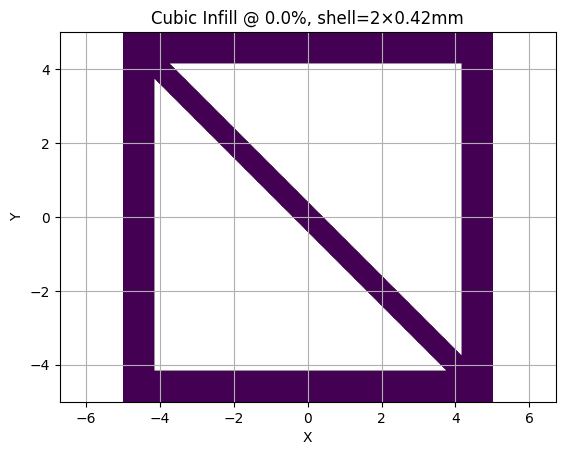

==== Infill 0.0% ====
Total Area            = 37.9771
Shell Area            = 31.2661
Infill Area           = 6.7110
Centroid (x_c, y_c)   = (-0.0000, -0.0000)
I_x                   = 479.1911
I_y                   = 479.1911
I_xy                  = -36.7507
Polar moment J        = 958.3821



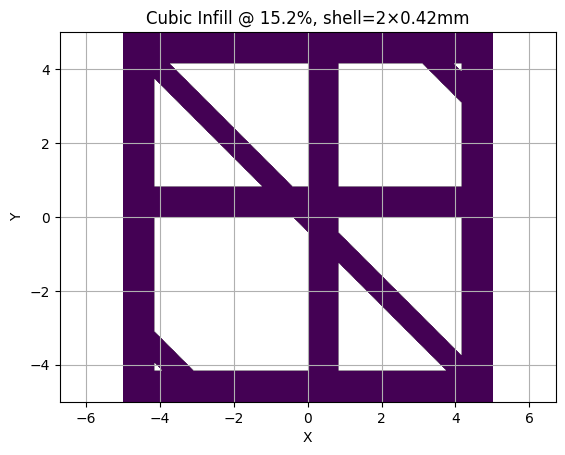

==== Infill 15.2% ====
Total Area            = 50.8634
Shell Area            = 31.2661
Infill Area           = 19.5972
Centroid (x_c, y_c)   = (0.0506, 0.0506)
I_x                   = 535.5728
I_y                   = 535.5728
I_xy                  = -21.0498
Polar moment J        = 1071.1456



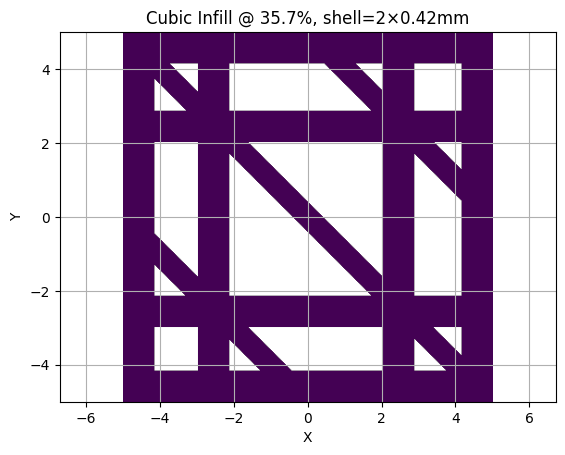

==== Infill 35.7% ====
Total Area            = 65.4443
Shell Area            = 31.2661
Infill Area           = 34.1782
Centroid (x_c, y_c)   = (-0.0094, -0.0094)
I_x                   = 649.8502
I_y                   = 649.8502
I_xy                  = -6.8127
Polar moment J        = 1299.7004



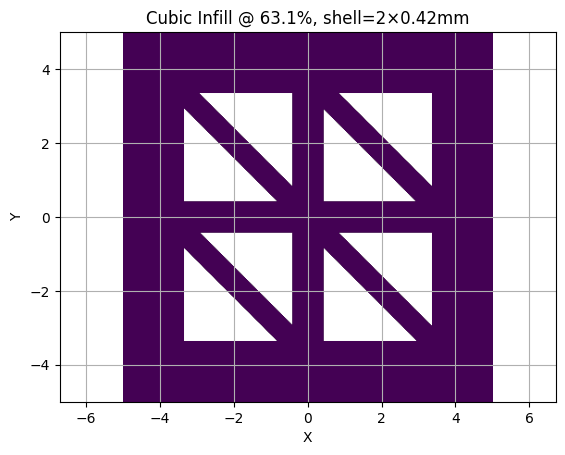

==== Infill 63.1% ====
Total Area            = 75.2508
Shell Area            = 31.2661
Infill Area           = 43.9846
Centroid (x_c, y_c)   = (-0.0000, -0.0000)
I_x                   = 732.3665
I_y                   = 732.3665
I_xy                  = -5.2029
Polar moment J        = 1464.7331



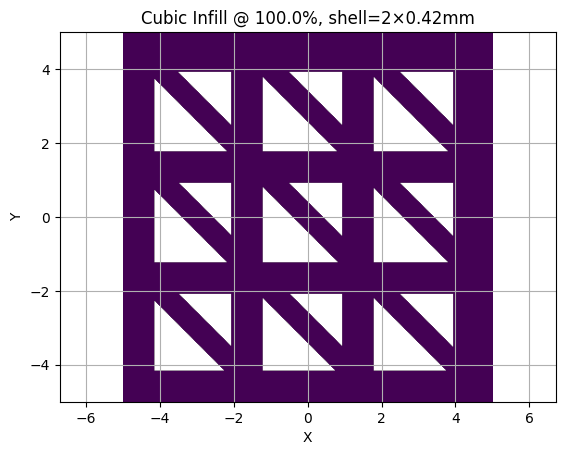

==== Infill 100.0% ====
Total Area            = 73.5416
Shell Area            = 31.2661
Infill Area           = 42.2755
Centroid (x_c, y_c)   = (0.0571, 0.0571)
I_x                   = 671.1977
I_y                   = 671.1977
I_xy                  = -3.7551
Polar moment J        = 1342.3955



In [2]:
import numpy as np
import matplotlib.pyplot as plt

def compute_area_moments(XX, YY, mask):
    dx = XX[0, 1] - XX[0, 0] if XX.shape[1] > 1 else 0.0
    dy = YY[1, 0] - YY[0, 0] if YY.shape[0] > 1 else 0.0
    dA = dx * dy

    A = np.count_nonzero(mask) * dA
    if A == 0:
        return {"A": 0.0, "x_c": 0.0, "y_c": 0.0, "I_x": 0.0, "I_y": 0.0, "I_xy": 0.0, "J": 0.0}

    x_vals = XX[mask]
    y_vals = YY[mask]
    x_c = np.sum(x_vals * dA) / A
    y_c = np.sum(y_vals * dA) / A

    x_shift = x_vals - x_c
    y_shift = y_vals - y_c

    I_x = np.sum((y_shift**2) * dA)
    I_y = np.sum((x_shift**2) * dA)
    I_xy = np.sum((x_shift * y_shift) * dA)
    J = I_x + I_y

    return {"A": A, "x_c": x_c, "y_c": y_c, "I_x": I_x, "I_y": I_y, "I_xy": I_xy, "J": J}

def geometric_infill_fractions(width, layer_width, shell_layers, steps=5):
    A_total = width ** 2
    shell_thickness = 2 * layer_width * shell_layers
    A_shell = A_total - (width - shell_thickness) ** 2
    r = (A_total / A_shell) ** (1 / (steps - 1))
    return [(A_shell * r**i - A_shell) / (A_total - A_shell) for i in range(steps)]

def cubic_corner_infill_rectangular_with_shell_fractional(
    width=20.0,
    height=20.0,
    spacing=5.0,
    infill_fraction=1.0,
    line_thickness=0.2,
    z_height=0.0,
    shell_layers=3,
    layer_width=0.4,
    plot=True
):
    N = 400
    xs = np.linspace(-width / 2, width / 2, N)
    ys = np.linspace(-height / 2, height / 2, N)
    XX, YY = np.meshgrid(xs, ys)
    Z = z_height

    def dist_mod(coord, spc):
        remainder = np.mod(coord, spc)
        return np.minimum(remainder, spc - remainder)

    effective_spacing = spacing / np.sqrt(infill_fraction) if infill_fraction > 0 else 1e6

    dist1 = dist_mod(XX + YY, effective_spacing)
    dist2 = dist_mod(XX + Z, effective_spacing)
    dist3 = dist_mod(YY + Z, effective_spacing)

    pattern_mask = (
        (dist1 < line_thickness) |
        (dist2 < line_thickness) |
        (dist3 < line_thickness)
    )

    if infill_fraction >= 1.0:
        pattern_mask = np.ones_like(pattern_mask, dtype=bool)

    shell_thickness = shell_layers * layer_width
    outer_rect = (
        (np.abs(XX) <= width / 2) &
        (np.abs(YY) <= height / 2)
    )
    inner_rect = (
        (np.abs(XX) <= (width / 2 - shell_thickness)) &
        (np.abs(YY) <= (height / 2 - shell_thickness))
    )

    shell_mask = outer_rect & (~inner_rect)
    infill_mask = pattern_mask & inner_rect
    final_mask = shell_mask | infill_mask

    total_moments = compute_area_moments(XX, YY, final_mask)
    shell_moments = compute_area_moments(XX, YY, shell_mask)
    infill_area = total_moments["A"] - shell_moments["A"]

    if plot:
        plt.figure()
        pattern_img = np.where(final_mask, 1.0, np.nan)
        plt.imshow(pattern_img, origin='lower', extent=[-width / 2, width / 2, -height / 2, height / 2])
        plt.title(f'Cubic Infill @ {infill_fraction*100:.1f}%, shell={shell_layers}×{layer_width}mm')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.axis('equal')
        plt.grid(True)
        plt.show()

    print(f"==== Infill {infill_fraction*100:.1f}% ====")
    print(f"Total Area            = {total_moments['A']:.4f}")
    print(f"Shell Area            = {shell_moments['A']:.4f}")
    print(f"Infill Area           = {infill_area:.4f}")
    print(f"Centroid (x_c, y_c)   = ({total_moments['x_c']:.4f}, {total_moments['y_c']:.4f})")
    print(f"I_x                   = {total_moments['I_x']:.4f}")
    print(f"I_y                   = {total_moments['I_y']:.4f}")
    print(f"I_xy                  = {total_moments['I_xy']:.4f}")
    print(f"Polar moment J        = {total_moments['J']:.4f}")
    print()

# --- RUN SIMULATION ---
if __name__ == "__main__":
    width = 10
    shell_layers = 2
    layer_width = 0.42
    spacing = 3.0
    line_thickness = 0.42  # realistic for a 0.4 mm nozzle
    steps = 5

    fractions = geometric_infill_fractions(width, layer_width, shell_layers, steps=steps)

    for f in fractions:
        cubic_corner_infill_rectangular_with_shell_fractional(
            width=width,
            height=width,
            spacing=spacing,
            infill_fraction=f,
            line_thickness=line_thickness,
            z_height=22.65,
            shell_layers=shell_layers,
            layer_width=layer_width,
            plot=True
        )


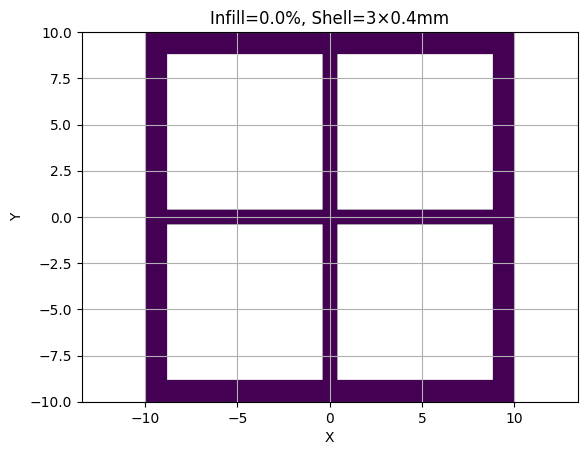

==== Infill 0.0% ====
Total Area            = 118.3510
Shell Area            = 90.6929
Infill Area           = 27.6581
I_x                   = 5758.9127
I_y                   = 5758.9127
I_xy                  = -0.0000
Polar moment J        = 11517.8255



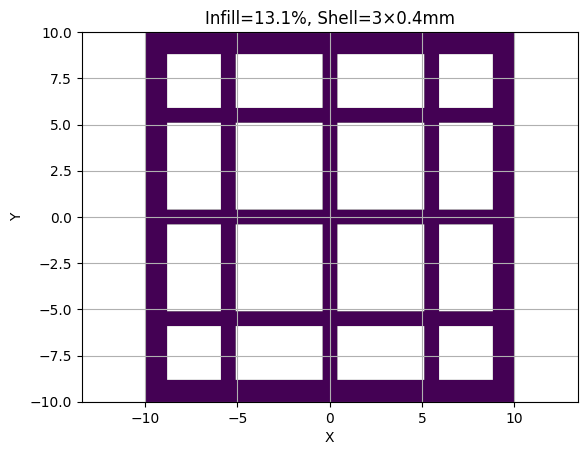

==== Infill 13.1% ====
Total Area            = 169.8080
Shell Area            = 90.6929
Infill Area           = 79.1151
I_x                   = 7237.4443
I_y                   = 7237.4443
I_xy                  = 0.0000
Polar moment J        = 14474.8886



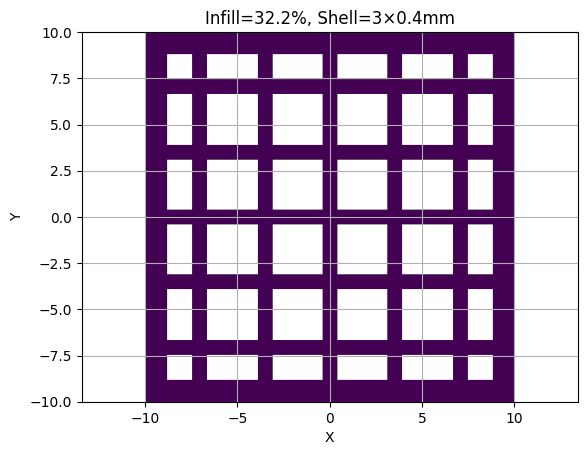

==== Infill 32.2% ====
Total Area            = 216.1192
Shell Area            = 90.6929
Infill Area           = 125.4263
I_x                   = 8591.1870
I_y                   = 8591.1870
I_xy                  = -0.0000
Polar moment J        = 17182.3741



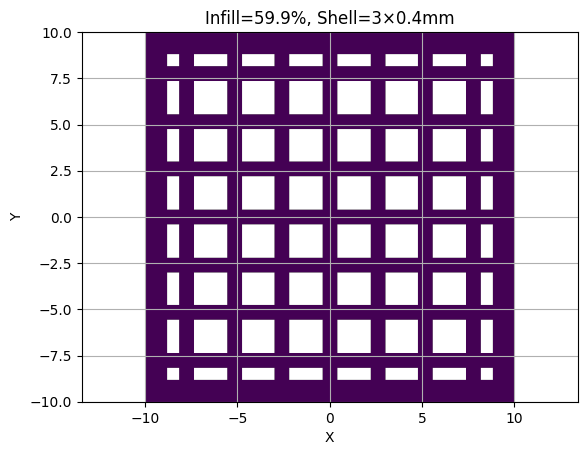

==== Infill 59.9% ====
Total Area            = 257.2848
Shell Area            = 90.6929
Infill Area           = 166.5919
I_x                   = 9774.6930
I_y                   = 9774.6930
I_xy                  = 0.0000
Polar moment J        = 19549.3860



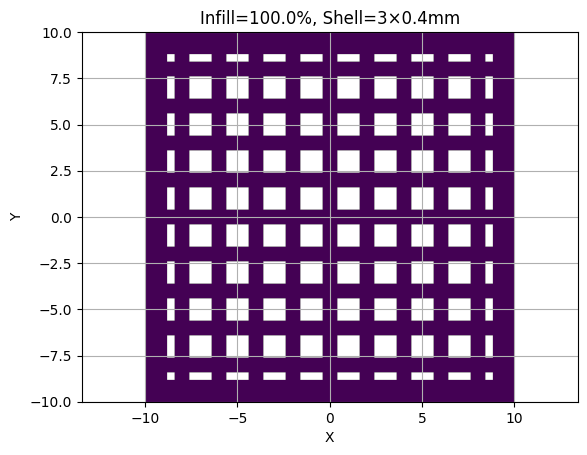

==== Infill 100.0% ====
Total Area            = 293.3047
Shell Area            = 90.6929
Infill Area           = 202.6118
I_x                   = 10715.9519
I_y                   = 10715.9519
I_xy                  = 0.0000
Polar moment J        = 21431.9039



In [21]:
import numpy as np
import matplotlib.pyplot as plt

def compute_area_moments(XX, YY, mask):
    dx = XX[0, 1] - XX[0, 0] if XX.shape[1] > 1 else 0.0
    dy = YY[1, 0] - YY[0, 0] if YY.shape[0] > 1 else 0.0
    dA = dx * dy

    A = np.count_nonzero(mask) * dA
    if A == 0:
        return {"A": 0.0, "x_c": 0.0, "y_c": 0.0, "I_x": 0.0, "I_y": 0.0, "I_xy": 0.0, "J": 0.0}

    x_vals = XX[mask]
    y_vals = YY[mask]
    x_c = np.sum(x_vals * dA) / A
    y_c = np.sum(y_vals * dA) / A

    x_shift = x_vals - x_c
    y_shift = y_vals - y_c

    I_x = np.sum((y_shift**2) * dA)
    I_y = np.sum((x_shift**2) * dA)
    I_xy = np.sum((x_shift * y_shift) * dA)
    J = I_x + I_y

    return {"A": A, "x_c": x_c, "y_c": y_c, "I_x": I_x, "I_y": I_y, "I_xy": I_xy, "J": J}

def geometric_infill_fractions(width, layer_width, shell_layers, steps=5):
    A_total = width ** 2
    shell_thickness = 2 * layer_width * shell_layers
    A_shell = A_total - (width - shell_thickness) ** 2
    r = (A_total / A_shell) ** (1 / (steps - 1))

    fractions = []
    for i in range(steps):
        A_i = A_shell * (r ** i)
        f = (A_i - A_shell) / (A_total - A_shell)
        fractions.append(f)
    return fractions

def grid_infill_rectangular_with_shell(width, height, spacing, infill_fraction,
                                       line_thickness, shell_layers, layer_width, plot=True):
    N = 400
    xs = np.linspace(-width / 2, width / 2, N)
    ys = np.linspace(-height / 2, height / 2, N)
    XX, YY = np.meshgrid(xs, ys)

    def dist_mod(coord, spc):
        remainder = np.mod(coord, spc)
        return np.minimum(remainder, spc - remainder)

    effective_spacing = spacing / np.sqrt(infill_fraction) if infill_fraction > 0 else 1e6
    dist_x = dist_mod(XX, effective_spacing)
    dist_y = dist_mod(YY, effective_spacing)
    pattern_mask = (dist_x < line_thickness) | (dist_y < line_thickness)

    shell_thickness = shell_layers * layer_width
    outer_rect = (np.abs(XX) <= width / 2) & (np.abs(YY) <= height / 2)
    inner_rect = (np.abs(XX) <= (width / 2 - shell_thickness)) & (np.abs(YY) <= (height / 2 - shell_thickness))

    shell_mask = outer_rect & (~inner_rect)
    infill_mask = pattern_mask & inner_rect
    final_mask = shell_mask | infill_mask

    total_moments = compute_area_moments(XX, YY, final_mask)
    shell_moments = compute_area_moments(XX, YY, shell_mask)
    infill_area = total_moments["A"] - shell_moments["A"]

    if plot:
        plt.figure()
        pattern_img = np.where(final_mask, 1.0, np.nan)
        plt.imshow(pattern_img, origin='lower', extent=[-width / 2, width / 2, -height / 2, height / 2])
        plt.title(f"Infill={infill_fraction*100:.1f}%, Shell={shell_layers}×{layer_width}mm")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.axis("equal")
        plt.grid(True)
        plt.show()

    print(f"==== Infill {infill_fraction*100:.1f}% ====")
    print(f"Total Area            = {total_moments['A']:.4f}")
    print(f"Shell Area            = {shell_moments['A']:.4f}")
    print(f"Infill Area           = {infill_area:.4f}")
    print(f"I_x                   = {total_moments['I_x']:.4f}")
    print(f"I_y                   = {total_moments['I_y']:.4f}")
    print(f"I_xy                  = {total_moments['I_xy']:.4f}")
    print(f"Polar moment J        = {total_moments['J']:.4f}")
    print()

    return total_moments

# ---- Run 5 levels with geometric infill growth ----
if __name__ == "__main__":
    width = 20.0
    shell_layers = 3
    layer_width = 0.4
    spacing = 2.0
    line_thickness = 0.4

    fractions = geometric_infill_fractions(width, layer_width, shell_layers, steps=5)

    for f in fractions:
        grid_infill_rectangular_with_shell(
            width=width,
            height=width,
            spacing=spacing,
            infill_fraction=f,
            line_thickness=line_thickness,
            shell_layers=shell_layers,
            layer_width=layer_width,
            plot=True
        )
